In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

from flight_safety.queries import (get_events_accidents, 
        get_aircrafts_accidents, get_occurrences_accidents,
        get_seq_of_events_accidents, get_flight_time_accidents,
        get_flight_crew_accidents)

In [2]:
mpl.rcParams['figure.figsize'] = 10, 6
mpl.rcParams['font.size'] = 20

con = sqlite3.connect('data/avall.db')

events = get_events_accidents(con)
aircraft = get_aircrafts_accidents(con)
occurrences = get_occurrences_accidents(con)
seq_of_events = get_seq_of_events_accidents(con)
flight_time = get_flight_time_accidents(con)

# What kind of events occur?

In [3]:
try:
    occurrences.phase_flt_spec_gross.cat.add_categories('TOTAL', inplace=True)
except ValueError:
    print('TOTAL category exists')

phases_per_occurence = pd.crosstab(occurrences.Occurrence_Code, occurrences.phase_flt_spec_gross)
phases_per_occurence['TOTAL'] = phases_per_occurence.sum(axis=1)
phases_per_occurence.sort_values('TOTAL', inplace=True, ascending=False)
phases_per_occurence.iloc[:10].iloc[:, 1:-1]

phase_flt_spec_gross,Taxi,Takeoff,Climb,Cruise,Descent,Approach,Landing,Maneuvering,Other,Unknown
Occurrence_Code,,,,,,,,,,
In flight encounter with weather,0,2,19,98,71,14,2,0,0,0
On ground/water collision with object,95,11,0,0,0,1,31,0,3,0
Miscellaneous/other,16,7,6,14,11,1,6,3,5,1
Airframe/component/system failure/malfunction,9,27,21,15,7,18,14,0,1,0
In flight collision with terrain/water,0,13,0,3,19,5,18,3,0,0
In flight collision with object,0,10,1,4,1,15,3,1,0,0
Loss of control - in flight,0,15,1,5,4,7,2,0,0,0
Hard landing,0,0,0,0,0,0,33,0,0,0
Fire,1,5,3,5,2,3,5,0,0,0


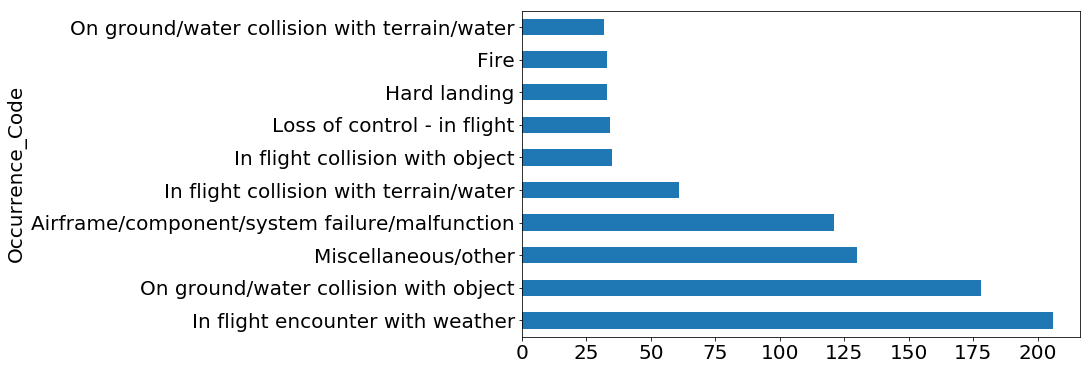

In [4]:
phases_per_occurence.iloc[:10].loc[:, 'TOTAL'].plot.barh();

# When do they occur?

In [5]:
aux = occurrences.Occurrence_Code.value_counts().iloc[0:10]
aux
occurrences_red = occurrences[occurrences['Occurrence_Code'].isin(aux.index)]

occurrences_per_phase = pd.crosstab(occurrences_red.phase_flt_spec_gross, occurrences_red.Occurrence_Code)
occurrences_per_phase = occurrences_per_phase.loc[['Standing', 'Taxi', 'Takeoff', 'Climb', 'Cruise', 'Descent', 'Approach',
       'Landing', 'Maneuvering']]

occurrences_per_phase

Occurrence_Code,Airframe/component/system failure/malfunction,Fire,Hard landing,In flight collision with object,In flight collision with terrain/water,In flight encounter with weather,Loss of control - in flight,On ground/water collision with object,On ground/water collision with terrain/water,Miscellaneous/other
phase_flt_spec_gross,,,,,,,,,,
Standing,9,9,0,0,0,0,0,37,0,60
Taxi,9,1,0,0,0,0,0,95,4,16
Takeoff,27,5,0,10,13,2,15,11,7,7
Climb,21,3,0,1,0,19,1,0,0,6
Cruise,15,5,0,4,3,98,5,0,0,14
Descent,7,2,0,1,19,71,4,0,0,11
Approach,18,3,0,15,5,14,7,1,0,1
Landing,14,5,33,3,18,2,2,31,20,6
Maneuvering,0,0,0,1,3,0,0,0,0,3


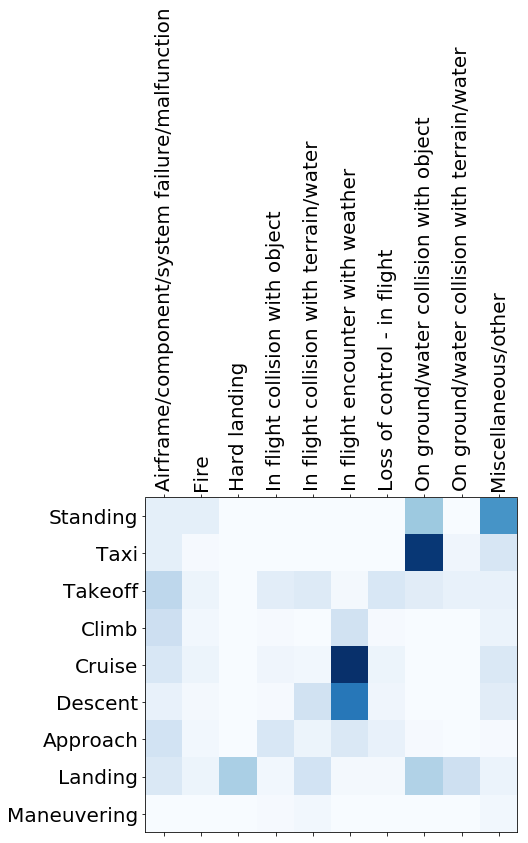

In [6]:
plt.figure(figsize=(20, 20))
occurrences_per_phase_ = occurrences_per_phase.iloc
plt.matshow(occurrences_per_phase.values, cmap=plt.cm.Blues)
plt.xticks(np.arange(occurrences_per_phase.shape[1]),
           occurrences_per_phase.columns.tolist(),
           rotation='vertical')
plt.yticks(np.arange(occurrences_per_phase.shape[0]),
           occurrences_per_phase.index.tolist());

# Which occurrences cause more victims?

In [7]:
occurrences_ = pd.merge(occurrences, events, left_on='ev_id', right_index=True)

inj_cols = ['inj_tot_f', 'inj_tot_s', 'inj_tot_m', 'inj_tot_n', 'inj_tot_t']

inj_per_occ = occurrences_.groupby('Occurrence_Code')[inj_cols].sum()
inj_per_occ.sort_values('inj_tot_t', inplace=True, ascending=False)

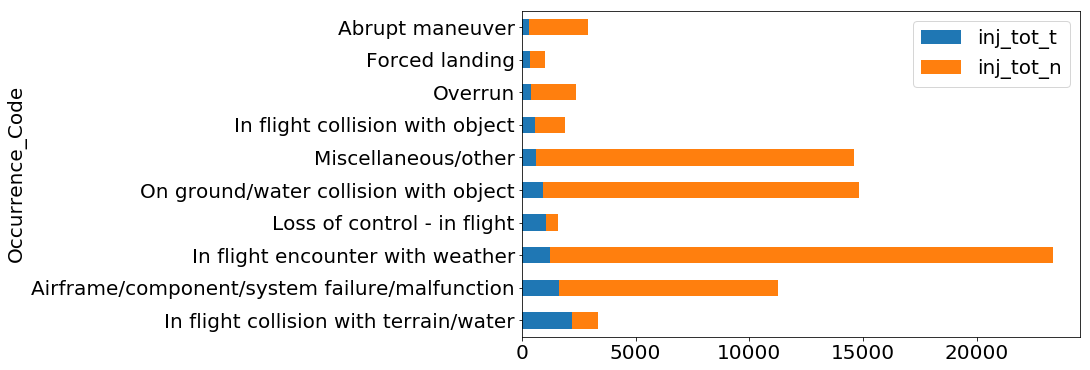

In [8]:
inj_per_occ.loc[inj_per_occ.index[:10], ['inj_tot_t', 'inj_tot_n']].plot.barh(stacked=True);

In [9]:
inj_per_occ['inj_tot_s+m'] = inj_per_occ['inj_tot_s'] + inj_per_occ['inj_tot_m']

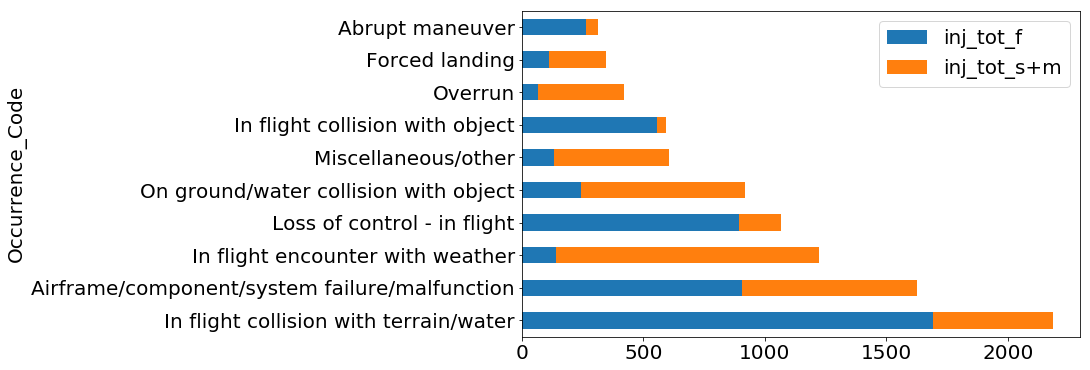

In [10]:
inj_per_occ.loc[inj_per_occ.index[:10], ['inj_tot_f', 'inj_tot_s+m']].plot.barh(stacked=True);

# Which phase of flight is more destructive for the airplane?

In [11]:
try:
    aircraft.damage.cat.add_categories(['TOTAL'], inplace=True)
except ValueError:
    pass

damage_per_Occurrence = pd.crosstab(occurrences.Occurrence_Code, aircraft.damage)
damage_per_Occurrence['TOTAL'] = damage_per_Occurrence.sum(axis=1)
damage_per_Occurrence.sort_values('TOTAL', inplace=True, ascending=False)
damage_per_Occurrence.head()

damage,,DEST,MINR,NONE,SUBS,UNK,TOTAL
Occurrence_Code,,,,,,,
In flight encounter with weather,0,14,17,77,84,0,192
On ground/water collision with object,1,14,9,58,85,0,167
Miscellaneous/other,0,10,12,50,53,0,125
Airframe/component/system failure/malfunction,0,10,11,39,58,0,118
In flight collision with terrain/water,0,3,8,20,25,0,56


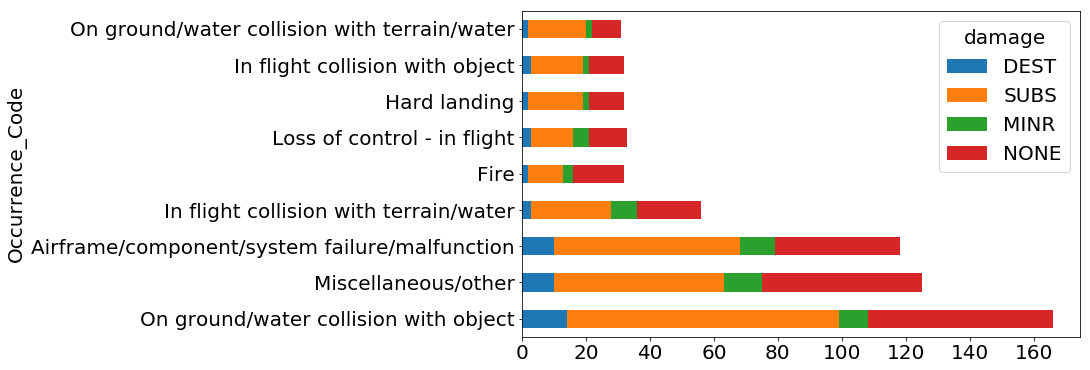

In [12]:
damage_per_Occurrence.loc[damage_per_Occurrence.index[1:10], ['DEST', 'SUBS', 'MINR', 'NONE']].plot.barh(stacked=True);

In [13]:
# Influence of fire in an accident

In [14]:
aircraft_with_phase = aircraft[aircraft.phase_flt_spec_gross != 0]

In [15]:
# f: fatal
# m: medium
# n: none
# s: serious
# t: f+s+m

# TODO: borrar injuries
injury_types = ['inj_tot_f', 'inj_tot_s', 'inj_tot_m', 'inj_tot_n', 'inj_tot_t']

aircraft_2 = aircraft_with_phase.join(events, on='ev_id', how='inner', rsuffix='e')

injuries_per_phase = aircraft_2[injury_types + ['phase_flt_spec_gross']].groupby('phase_flt_spec_gross').sum()
injuries_per_phase.sort_values('inj_tot_t', inplace=True, ascending=False)
injuries_per_phase = injuries_per_phase.iloc[:10]
injuries_per_phase['inj_tot_s+m'] = injuries_per_phase['inj_tot_s'] + injuries_per_phase['inj_tot_m']
injuries_per_phase

,inj_tot_f,inj_tot_s,inj_tot_m,inj_tot_n,inj_tot_t,inj_tot_s+m
phase_flt_spec_gross,,,,,,
Takeoff,857.0,120.0,382.0,6266.0,1359.0,502.0
Cruise,367.0,159.0,670.0,14198.0,1196.0,829.0
Landing,195.0,153.0,599.0,11018.0,947.0,752.0
Approach,522.0,65.0,74.0,2375.0,661.0,139.0
Climb,370.0,42.0,94.0,4895.0,506.0,136.0
Descent,89.0,105.0,212.0,9450.0,406.0,317.0
Standing,12.0,65.0,196.0,9675.0,273.0,261.0
Taxi,14.0,45.0,201.0,13961.0,260.0,246.0
Maneuvering,72.0,4.0,3.0,165.0,79.0,7.0


In [16]:
def tot_events_and_mean_injuries_by_factor(factor):
    ac_ = aircraft_2[[
    'ev_id',
    'inj_tot_f', 'inj_tot_m', 'inj_tot_n', 'inj_tot_s', 'inj_tot_t',
    'apt_dist', 'apt_dir', 'light_cond', 'sky_cond_nonceil',
    'gust_ind', 'gust_kts',
    'damage', 'acft_fire', 'acft_expl', 'acft_make', 'acft_model', 'acft_category',
    'afm_hrs', 'afm_hrs_last_insp', 'num_eng', 'far_part', 
    ]]
    
    gby = ac_.groupby([factor])
    r = gby.agg({'ev_id': 'count',
                 'inj_tot_f':'mean',
                 'inj_tot_m':'mean',
                 'inj_tot_n':'mean',
                 'inj_tot_s':'mean',
                 'inj_tot_t':'mean'}
           )
    
    if factor in ('acft_fire', 'acft_expl'):
        r = r.loc[['GRD ', 'IFLT', 'NONE', 'UNK ']]
    elif factor in ('gust_ind'):
        r = r.loc[['N', 'Y']]
    
    return r.loc[:, ['ev_id', 'inj_tot_f']]

# EN acft_fire u acft_expl drop blaco y BOTH
# EN gust_ind drop blanco
# EVALUAR light_cond y sky_con_nonceil

In [17]:
tot_events_and_mean_injuries_by_factor('acft_fire')

,ev_id,inj_tot_f
acft_fire,,
GRD,93,37.512821
IFLT,18,47.500000
NONE,910,6.684211
UNK,25,66.714286
